In [180]:
#! /usr/bin/env python3
'''===============================================================================================================
 - Author: M. Guesmi
 - Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany
 - Summary: test different machine learning models to classfiy flow pattern based on operational and geometrical features 
=================================================================================================================='''

'===============================================================================================================\n - Author: M. Guesmi\n - Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany\n - Summary: test different machine learning models to classfiy flow pattern based on operational and geometrical features \n=================================================================================================================='

In [181]:
#!python -m pip install --upgrade pip
#!python -m pip install seaborn==0.13.0
# only if xgboost was not installed yet
#!python -m pip install xgboost==2.0.0
#!python -m pip install numpy==1.21.3 scipy==1.10.1
#!python -m pip  install  scikit-learn==1.3.1  imbalanced-learn==0.11.0
#!python -m pip  install tabulate


In [182]:
#!python -m uninstall numpy scipy scikit-learn imbalanced-learn
#!python -m install numpy=1.22.4 scipy=1.7.3 scikit-learn=1.3.1 imbalanced-learn=0.11.0


In [183]:
import numpy as np     # linear algebra
import pandas as pd     
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import imblearn
# ML models 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Evaluation metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import LabelBinarizer
import pickle
from tabulate import tabulate
from IPython.display import display, HTML
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE # for oversampling of minor classes
from collections import Counter

# import joblib to import model to file
import joblib

In [184]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Ignore the UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [185]:
df = pd.read_csv('training_test_data.csv',sep=',')

In [186]:
df.describe()

,Vsl,Vsg,DenL,DenG,VisL,VisG,ST,ID,Ang,Flow_label
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3.523000e+03,3523.000000,3523.000000,3523.000000,3523.000000
mean,0.902791,6.836029,963.239290,3.705230,0.012039,1.317070e-05,0.065915,0.046693,0.333272,2.458132
std,1.351430,13.410838,146.653889,6.519686,0.071802,4.577323e-06,0.013631,0.025207,4.193035,1.035510
min,0.000241,0.014967,77.041602,0.125000,0.000012,5.070000e-07,0.015000,0.008740,-10.000000,0.000000
25%,0.033713,0.400000,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.025000,0.000000,2.000000
50%,0.250000,1.969150,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.051000,0.250000,3.000000
75%,1.012195,10.000000,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.051000,1.030000,3.000000
max,6.475590,200.609756,1000.000000,26.900000,0.483000,1.900000e-05,0.070000,0.106400,10.000000,4.000000


In [187]:
df

,Author,Vsl,Vsg,DenL,DenG,VisL,VisG,ST,ID,Ang,Flow_label
0,1985_Piu-,0.044817,0.814024,1000.0,1.12,0.001,0.000015,0.07,0.0254,0.0,1
1,1985_Piu-,0.060976,0.814024,1000.0,1.12,0.001,0.000015,0.07,0.0254,0.0,3
2,1985_Piu-,0.088110,0.814024,1000.0,1.12,0.001,0.000015,0.07,0.0254,0.0,3
3,1985_Piu-,0.060976,1.103659,1000.0,1.12,0.001,0.000015,0.07,0.0254,0.0,3
4,1985_Piu-,0.121951,1.103659,1000.0,1.12,0.001,0.000015,0.07,0.0254,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...
3518,1982_Ovad,1.500000,15.000000,1000.0,1.18,0.001,0.000015,0.07,0.0250,-10.0,3
3519,1982_Ovad,0.600000,25.000000,1000.0,1.18,0.001,0.000015,0.07,0.0250,-10.0,3
3520,1982_Ovad,1.000000,25.000000,1000.0,1.18,0.001,0.000015,0.07,0.0250,-10.0,3
3521,1982_Ovad,1.500000,25.000000,1000.0,1.18,0.001,0.000015,0.07,0.0250,-10.0,3


Recommended Approach for Continuous Features and Categorical Target
Given your scenario (continuous features and a categorical target), Mutual Information stands out as a particularly suitable choice. It can handle both types of data without needing to discretize your continuous variables and provides a measure of association that captures non-linear relationships, which are common in complex datasets.

In Python, you can use sklearn.feature_selection.mutual_info_classif to compute mutual information between each feature and the target. This approach gives you a quantitative measure of the importance of each feature in predicting the target classes without making strong assumptions about the nature of their relationship.

Correlation between Vsl and Flow Pattern: 0.5659112402624235
Correlation between Vsg and Flow Pattern: -0.12885307242413216
Correlation between DenL and Flow Pattern: -0.019858160134815034
Correlation between DenG and Flow Pattern: 0.1333701306814368
Correlation between VisL and Flow Pattern: 0.0026341204959098126
Correlation between VisG and Flow Pattern: -0.12990230323786767
Correlation between ID and Flow Pattern: 0.1357908180811833
Correlation between Ang and Flow Pattern: 0.27219734378163346


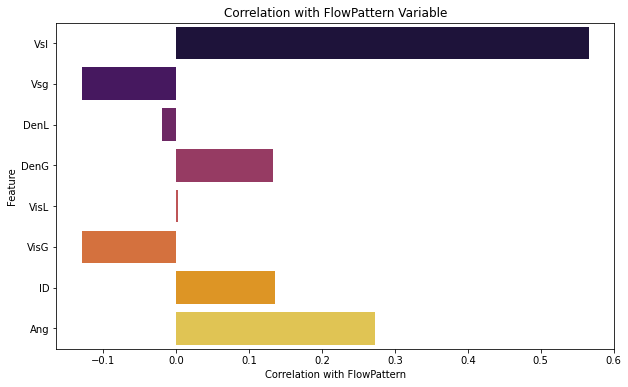

In [188]:
# Calculate the correlation between each feature and the Flow pattern
# nice to try but this technique is not suitable!!!!
correlation_df = pd.DataFrame(columns=['Feature', 'Correlation with FlowPattern'])

for feature in df.drop(columns=['Author', 'ST', 'Flow_label']).columns:
#for feature in df.drop(columns=['Author', 'Flow_label']).columns:
    #correlation    = df[feature].corr(df['Flow_label'])
    correlation = df[feature].corr(df['Flow_label'])
    print(f"Correlation between {feature} and Flow Pattern: {correlation}")
    correlation_df = pd.concat([correlation_df, pd.DataFrame({'Feature': [feature], 'Correlation with FlowPattern': [correlation]})], ignore_index=True)

# Generate a bar plot to visualize the correlation with the Flow pattern
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with FlowPattern', y='Feature', data=correlation_df, palette='inferno')
plt.title('Correlation with FlowPattern Variable')
plt.show()

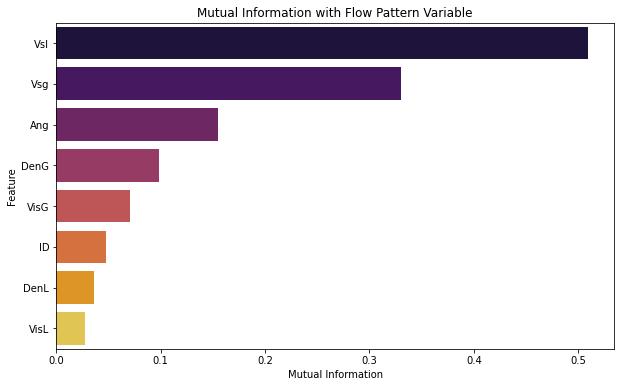

In [189]:
from sklearn.feature_selection import mutual_info_classif

# Assuming df is your DataFrame and 'Flow_label' is your target variable

# Prepare your features and target variable
X = df.drop(columns=['Author', 'ST', 'Flow_label'])
# consider the effect of ST
#X = df.drop(columns=['Author', 'Flow_label'])
y = df['Flow_label']

# Calculate Mutual Information
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame for easier plotting
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Sort the DataFrame by Mutual Information scores
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='inferno')
plt.title('Mutual Information with Flow Pattern Variable')
plt.show()


In [190]:
# Split the dataset into train and test sets
# Features
X = df.drop(columns=['Author','ST', 'Flow_label'], axis=1)   
# consider the effect of ST 
#X = df.drop(columns=['Author', 'Flow_label'], axis=1)   
# Target variable
y = df['Flow_label']   
print("Original class distribution:", Counter(y))                       
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train_data = pd.concat([X_train, y_train], axis=1)
print('everything is fine sofar!')

Original class distribution: Counter({3: 1848, 1: 648, 2: 522, 4: 356, 0: 149})
everything is fine sofar!


In [191]:
# Perform oversampling 
# List of oversampling techniques
oversamplers = {
    'RandomOverSampler': RandomOverSampler(sampling_strategy='auto', random_state=42),
    'SMOTE': SMOTE(sampling_strategy='auto', random_state=42),
    'ADASYN': ADASYN(sampling_strategy='auto', random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(sampling_strategy='auto', random_state=42),
    'SVMSMOTE': SVMSMOTE(sampling_strategy='auto', random_state=42)
}
# Apply each oversampling technique
for name, sampler in oversamplers.items():
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"\nOversampler: {name}")
    print(f"Resampled class distribution:", Counter(y_resampled))
    


Oversampler: RandomOverSampler
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: SMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: ADASYN
Resampled class distribution: Counter({1: 1502, 2: 1477, 3: 1473, 0: 1463, 4: 1448})

Oversampler: BorderlineSMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: SVMSMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})


In [192]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]}

# Initialize SVC with RBF kernel
svc_classifier = SVC(kernel='linear', max_iter=20000)

# Initialize GridSearchCV
grid_search = GridSearchCV(svc_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")


Best parameters: {'C': 0.1, 'gamma': 'scale'}
Best score: 0.7349293929430735


In [193]:
# Imbalanced data --> use different techniques 
# Using different classifiers 
# Initialize different classifiers
classifiers = {
    'XGBClassifier': XGBClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=20000),
    'Support Vector Machine': SVC(kernel='linear', C=0.1, gamma='scale', max_iter=20000)
}
# Generate y_pred for each classifier
y_preds = {}
# Initialize a list to store the results of accuracy
results = []
models_accuracies=[]
model_oversampler_accuracy=[]
# Train and evaluate each classifier
k = -1 
for name, clf in classifiers.items():
    k = k + 1
    # test each technique
    best_accuracy = 0.
    for name_oversampler, sampler in oversamplers.items():
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        if (k < 1):  # print resamling only once
            print(f"\nOversampler: {name_oversampler}")
            print(f"Resampled class distribution:", Counter(y_resampled))
        # Train the classifier
        clf.fit(X_resampled, y_resampled)
    
        # Make predictions on the test set
        y_pred = clf.predict(X_test)

        # Evaluate the model
        accuracy      = accuracy_score(y_test, y_pred) * 100  # Multiply by 100 for percentage
        results.append([name, name_oversampler, f"{accuracy:.2f}%"])
        # Update best oversampler if necessary
        if accuracy > best_accuracy:
            best_oversampler = name_oversampler
            best_accuracy = accuracy
            y_pred_best   = y_pred
            
    y_preds[name] = y_pred  
    models_accuracies.append([name, best_accuracy])
    model_oversampler_accuracy.append([name,best_oversampler, best_accuracy]) 
        
    



Oversampler: RandomOverSampler
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: SMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: ADASYN
Resampled class distribution: Counter({1: 1502, 2: 1477, 3: 1473, 0: 1463, 4: 1448})

Oversampler: BorderlineSMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})

Oversampler: SVMSMOTE
Resampled class distribution: Counter({3: 1473, 0: 1473, 1: 1473, 2: 1473, 4: 1473})


In [194]:
# Print results as a table
print(tabulate(results, headers=["Model", " Oversampling technique", "Accuracy"], tablefmt="pretty"))

+------------------------+-------------------------+----------+
|         Model          |  Oversampling technique | Accuracy |
+------------------------+-------------------------+----------+
|     XGBClassifier      |    RandomOverSampler    |  94.61%  |
|     XGBClassifier      |          SMOTE          |  95.46%  |
|     XGBClassifier      |         ADASYN          |  95.32%  |
|     XGBClassifier      |     BorderlineSMOTE     |  94.75%  |
|     XGBClassifier      |        SVMSMOTE         |  94.04%  |
|     Decision Tree      |    RandomOverSampler    |  91.35%  |
|     Decision Tree      |          SMOTE          |  94.33%  |
|     Decision Tree      |         ADASYN          |  92.62%  |
|     Decision Tree      |     BorderlineSMOTE     |  92.62%  |
|     Decision Tree      |        SVMSMOTE         |  94.18%  |
|     Random Forest      |    RandomOverSampler    |  93.90%  |
|     Random Forest      |          SMOTE          |  94.75%  |
|     Random Forest      |         ADASY

In [195]:

# Sort the results by accuracy in descending order
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)
# Generate a table
table = tabulate(sorted_results, headers=['Model', 'Oversampler', 'Accuracy'], tablefmt='pretty')
print(table)

+------------------------+-------------------+----------+
|         Model          |    Oversampler    | Accuracy |
+------------------------+-------------------+----------+
|     XGBClassifier      |       SMOTE       |  95.46%  |
|     XGBClassifier      |      ADASYN       |  95.32%  |
|     XGBClassifier      |  BorderlineSMOTE  |  94.75%  |
|     Random Forest      |       SMOTE       |  94.75%  |
|     XGBClassifier      | RandomOverSampler |  94.61%  |
|     Random Forest      |     SVMSMOTE      |  94.47%  |
|     Decision Tree      |       SMOTE       |  94.33%  |
|     Random Forest      |  BorderlineSMOTE  |  94.33%  |
|     Decision Tree      |     SVMSMOTE      |  94.18%  |
|     Random Forest      |      ADASYN       |  94.18%  |
|     XGBClassifier      |     SVMSMOTE      |  94.04%  |
|     Random Forest      | RandomOverSampler |  93.90%  |
|     Decision Tree      |      ADASYN       |  92.62%  |
|     Decision Tree      |  BorderlineSMOTE  |  92.62%  |
|     Decision

In [196]:
# Define original labels and desired labels
original_labels = ['0', '1', '2', '3', '4']
desired_labels = ['SS', 'SW', 'A', 'I', 'DB']
#desired_labels = ['Smooth-Stratified', 'Wavy-Stratified', 'Annular', 'Slug', 'Bubbly']
# Create a dictionary to map original labels to desired labels
label_mapping = {original_labels[i]: desired_labels[i] for i in range(len(original_labels))}



['XGBClassifier', 'SMOTE', 95.46099290780143]


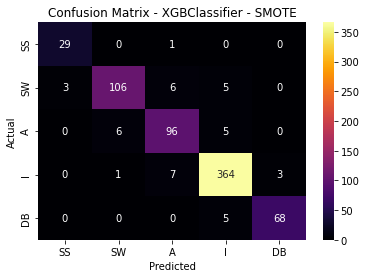

['Decision Tree', 'SMOTE', 94.32624113475178]


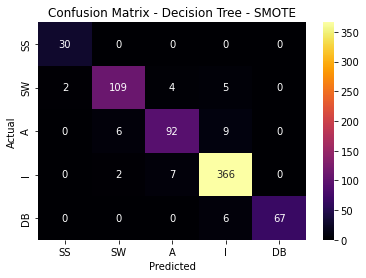

['Random Forest', 'SMOTE', 94.7517730496454]


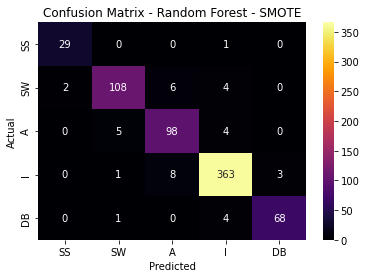

['Logistic Regression', 'RandomOverSampler', 67.23404255319149]


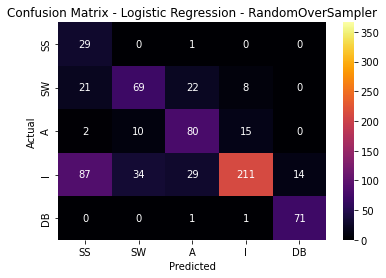

['Support Vector Machine', 'RandomOverSampler', 67.37588652482269]


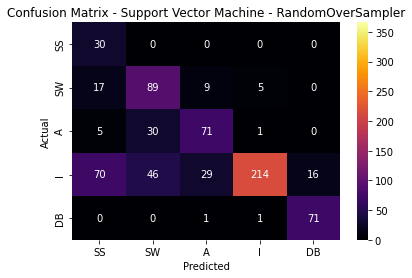

In [197]:

# Initialize a dictionary to store confusion matrices
confusion_matrices = {}

for name, y_pred in y_preds.items():
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

# Find the maximum value among all confusion matrices
max_value = max(np.max(cm) for cm in confusion_matrices.values())
# Plot the confusion matrices
k = -1 
for name, cm in confusion_matrices.items():
    k = k + 1 
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=desired_labels, yticklabels=desired_labels, vmin=0, vmax=max_value) # Reverse yticklabels
    print(model_oversampler_accuracy[k])
    
    # Get the corresponding value from the second list
    oversampler = model_oversampler_accuracy[k][1]
    
    plt.title(f'Confusion Matrix - {name} - {oversampler}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Create the confusion matrix using scikit-learn
    cm = confusion_matrix(y_test, y_pred)
    # Calculate row sums (total predictions for each class)
    row_sums = np.sum(cm, axis=1)
    # Calculate percentages
    percentages = cm / row_sums[:, np.newaxis] * 100  # Ensure division is element-wise
    #sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=desired_labels, yticklabels=desired_labels) # Reverse yticklabels

   

In [198]:
# Initialize a dictionary to store classification reports
classification_reports = {}

for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, target_names=desired_labels, zero_division=1, output_dict=True)
    report = classification_report(y_test, y_pred, zero_division=1)
    classification_reports[name] = report
    print(f"Classification Report - {name}:")
    # Display long output with scrolling
    display(HTML("<div style='max-height: 300px; overflow-y: auto;'>"  + "</div>"))
    print(classification_report(y_test, y_preds[name], target_names=desired_labels,zero_division=1))
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"--------------------------------")


Classification Report - XGBClassifier:


              precision    recall  f1-score   support

          SS       0.91      0.97      0.94        30
          SW       0.94      0.88      0.91       120
           A       0.87      0.90      0.88       107
           I       0.96      0.97      0.97       375
          DB       0.96      0.93      0.94        73

    accuracy                           0.94       705
   macro avg       0.93      0.93      0.93       705
weighted avg       0.94      0.94      0.94       705

Cohen's Kappa: 0.9084
--------------------------------
Classification Report - Decision Tree:


              precision    recall  f1-score   support

          SS       0.94      1.00      0.97        30
          SW       0.93      0.91      0.92       120
           A       0.89      0.86      0.88       107
           I       0.95      0.98      0.96       375
          DB       1.00      0.92      0.96        73

    accuracy                           0.94       705
   macro avg       0.94      0.93      0.94       705
weighted avg       0.94      0.94      0.94       705

Cohen's Kappa: 0.9101
--------------------------------
Classification Report - Random Forest:


              precision    recall  f1-score   support

          SS       0.94      0.97      0.95        30
          SW       0.94      0.90      0.92       120
           A       0.88      0.92      0.89       107
           I       0.97      0.97      0.97       375
          DB       0.96      0.93      0.94        73

    accuracy                           0.94       705
   macro avg       0.93      0.94      0.94       705
weighted avg       0.95      0.94      0.94       705

Cohen's Kappa: 0.9152
--------------------------------
Classification Report - Logistic Regression:


              precision    recall  f1-score   support

          SS       0.21      0.97      0.34        30
          SW       0.61      0.57      0.59       120
           A       0.60      0.75      0.67       107
           I       0.90      0.56      0.69       375
          DB       0.84      0.97      0.90        73

    accuracy                           0.65       705
   macro avg       0.63      0.76      0.64       705
weighted avg       0.77      0.65      0.68       705

Cohen's Kappa: 0.5341
--------------------------------
Classification Report - Support Vector Machine:


              precision    recall  f1-score   support

          SS       0.25      1.00      0.39        30
          SW       0.54      0.74      0.62       120
           A       0.65      0.66      0.65       107
           I       0.97      0.57      0.72       375
          DB       0.82      0.97      0.89        73

    accuracy                           0.67       705
   macro avg       0.64      0.79      0.66       705
weighted avg       0.80      0.67      0.70       705

Cohen's Kappa: 0.5648
--------------------------------


In [199]:
#list of models and their corresponding accuracies: models_accuracies
# Filter models with accuracy > 80%
selected_models = [model_info for model_info in models_accuracies if model_info[1] > 60]

# Print the selected models
for model_info in selected_models:
    print(f"Model: {model_info[0]}, Accuracy: {model_info[1]}%")

# Initialize a dictionary to store models with accuracy > 90%
high_accuracy_models = {}


# Iterate through the models
for model_name, model in classifiers.items():
    for model_info in selected_models:
        if (model_info[0] == model_name):
            high_accuracy_models[model_name] = model


print(high_accuracy_models)

Model: XGBClassifier, Accuracy: 95.46099290780143%
Model: Decision Tree, Accuracy: 94.32624113475178%
Model: Random Forest, Accuracy: 94.7517730496454%
Model: Logistic Regression, Accuracy: 67.23404255319149%
Model: Support Vector Machine, Accuracy: 67.37588652482269%
{'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num

In [200]:
# the selected models are already trained these models
# Load the new data set
validation_data = pd.read_csv('validation_data.csv')  
# Features
X_valid = df.drop(columns=['Author', 'ST', 'Flow_label'], axis=1)    
# consider the effect of ST (surface tension)   
#X_valid = df.drop(columns=['Author', 'Flow_label'], axis=1)   
# Target variable
y_valid = df['Flow_label'] 

# Initialize a dictionary to store predictions
predictions_dict = {}

# Loop through the selected models
for clf_name, clf in high_accuracy_models.items():
    # Make predictions
    prediction = clf.predict(X_valid)
    # Store predictions in the dictionary
    predictions_dict[clf_name] = prediction

#  predictions stored in predictions_dict
for clf_name, prediction in predictions_dict.items():
    accuracy = accuracy_score(y_valid, prediction)
    print(f"Accuracy for {clf_name}: {accuracy * 100 :.2f} %")

Accuracy for XGBClassifier: 98.64 %
Accuracy for Decision Tree: 98.81 %
Accuracy for Random Forest: 98.86 %
Accuracy for Logistic Regression: 67.30 %
Accuracy for Support Vector Machine: 68.52 %


In [201]:
# Print y_valid and y_pred side by side
for true, pred in zip(y_valid, predictions_dict[clf_name]):
    print(f"Actual: {true}, Predicted: {pred}")

Actual: 1, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 1, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 1, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 0
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 3, Predicted: 1
Actual: 1, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 1
Actual: 3, Predicted: 2
Actual: 3, Predicted: 2
Actual: 3, Predicted: 2
Actual: 3, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predi

In [202]:
# Save the trained model to a file
classifiers = {
    'XGBClassifier': XGBClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}
for name, model in classifiers.items():
    print(model)
    joblib.dump(model, name)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
DecisionTreeClassifier()
RandomForestClassifier()


In [206]:
import os
# Save the trained model to a file
classifiers = {
    'XGBClassifier-oversampled': XGBClassifier(),
    'Decision Tree-oversampled': DecisionTreeClassifier(),
    'Random Forest-oversampled': RandomForestClassifier()
}
for name, model in classifiers.items():
    model.fit(X_resampled, y_resampled)
# Define the path to the test directory relative to the notebooks directory
test_dir = os.path.join(os.path.dirname(os.getcwd()), 'test')

# Ensure the test directory exists
os.makedirs(test_dir, exist_ok=True)

# Save the models in the test directory
for name, model in classifiers.items():
    model_path = os.path.join(test_dir, f'{name}.joblib')
    joblib.dump(model, model_path)
    print(f"Model {name} saved to {model_path}")

Model XGBClassifier-oversampled saved to c:\Users\Administrator\Desktop\mini_project\test\XGBClassifier-oversampled.joblib
Model Decision Tree-oversampled saved to c:\Users\Administrator\Desktop\mini_project\test\Decision Tree-oversampled.joblib
Model Random Forest-oversampled saved to c:\Users\Administrator\Desktop\mini_project\test\Random Forest-oversampled.joblib
